<div style="border: 2px solid #ccc; padding: 20px; border-radius: 10px; background-color: #f8f9fa; font-family: Arial, sans-serif;">
  <h2 style="text-align: center; color: #2c3e50; margin-top: 0;">Web Scraping & Knowledge Base Construction</h2>
  
  <p style="text-align: center; font-size: 18px; margin: 10px 0;">
    <strong>Wendy DUONG</strong> &nbsp; | &nbsp; <strong>Ilan ZINI</strong>
  </p>
  
  <p style="text-align: center; font-size: 16px; color: #555; margin: 5px 0;">
    DIA6
  </p>
  
  <p style="text-align: center; font-size: 16px; color: #555; margin: 5px 0;">
    Part 1 – <strong>Web scrapping and knowledge base construction</strong>
  </p>
</div>

# **Environment Setup**

## Installation des librairies

In [40]:
pip install datasets sklearn-crfsuite transformers beautifulsoup4 nltk spacy

Note: you may need to restart the kernel to use updated packages.


## Chargement du dataset CoNLL-2003

In [41]:
from datasets import load_dataset

# Charger le dataset CoNLL-2003 depuis Hugging Face
dataset = load_dataset("conll2003", trust_remote_code=True)

# On extrait les sous-ensembles
train_dataset = dataset['train']
validation_dataset = dataset['validation']
test_dataset = dataset['test']

# Affichons un exemple pour voir la structure
print(train_dataset[0])

{'id': '0', 'tokens': ['EU', 'rejects', 'German', 'call', 'to', 'boycott', 'British', 'lamb', '.'], 'pos_tags': [22, 42, 16, 21, 35, 37, 16, 21, 7], 'chunk_tags': [11, 21, 11, 12, 21, 22, 11, 12, 0], 'ner_tags': [3, 0, 7, 0, 0, 0, 7, 0, 0]}


# **Task 1: Model for NER**

## **Step 1 - Text Cleaning & Preprocessing**

In [42]:
import spacy
from spacy.lang.en.stop_words import STOP_WORDS
import string

# Charger le modèle de langue en anglais
nlp = spacy.load("en_core_web_sm")

# Fonction de nettoyage
def clean_text(text_tokens):
    text = " ".join(text_tokens)  # joindre les tokens en une phrase
    doc = nlp(text)

    cleaned_tokens = []
    for token in doc:
        if token.text in string.punctuation and token.text != "-":
            continue  # on garde le '-' mais on enlève les autres ponctuations
        if token.is_stop:
            continue
        cleaned_tokens.append(token.lemma_.lower())  # lemmatization + lowercase

    return cleaned_tokens

# Exemple d'utilisation sur la 1ère phrase du dataset
example_tokens = train_dataset[0]["tokens"]
cleaned = clean_text(example_tokens)

print("Original tokens:", example_tokens)
print("Cleaned tokens:", cleaned)

Original tokens: ['EU', 'rejects', 'German', 'call', 'to', 'boycott', 'British', 'lamb', '.']
Cleaned tokens: ['eu', 'reject', 'german', 'boycott', 'british', 'lamb']


## **Step 2 - Named Entity Recognition (NER) avec modèle CRF**

### 2.1 Extraction de features pour CRF

In [43]:
# 🔁 Mappings des entiers vers les labels lisibles
pos_tag_list = dataset["train"].features["pos_tags"].feature.names
ner_tag_list = dataset["train"].features["ner_tags"].feature.names

# 🔄 Convertir un exemple en format exploitable pour CRF
def convert_conll_to_sent_format(example):
    return [
        {
            "word": w,
            "pos": pos_tag_list[pos],
            "ner": ner_tag_list[ner]
        }
        for w, pos, ner in zip(example["tokens"], example["pos_tags"], example["ner_tags"])
    ]

# 🔧 Extraire les features d’un mot dans une phrase
def word2features(sent, i):
    word = sent[i]['word']
    postag = sent[i]['pos']

    features = {
        'bias': 1.0,
        'word.lower()': word.lower(),
        'word[-3:]': word[-3:],
        'word[-2:]': word[-2:],
        'word.isupper()': word.isupper(),
        'word.istitle()': word.istitle(),
        'word.isdigit()': word.isdigit(),
        'postag': postag,
        'postag[:2]': postag[:2],
    }

    if i > 0:
        word1 = sent[i-1]['word']
        postag1 = sent[i-1]['pos']
        features.update({
            '-1:word.lower()': word1.lower(),
            '-1:postag': postag1,
        })
    else:
        features['BOS'] = True

    if i < len(sent)-1:
        word1 = sent[i+1]['word']
        postag1 = sent[i+1]['pos']
        features.update({
            '+1:word.lower()': word1.lower(),
            '+1:postag': postag1,
        })
    else:
        features['EOS'] = True

    return features

# 🔁 Transformer toute une phrase en liste de features / labels
def sent2features(sent):
    return [word2features(sent, i) for i in range(len(sent))]

def sent2labels(sent):
    return [token['ner'] for token in sent]

def sent2tokens(sent):
    return [token['word'] for token in sent]



# ✅ Test sur un exemple
sample = convert_conll_to_sent_format(train_dataset[0])

print("Features pour le mot 0 (EU):")
print(sent2features(sample)[0])

print("\nNER Tags:")
print(sent2labels(sample))

Features pour le mot 0 (EU):
{'bias': 1.0, 'word.lower()': 'eu', 'word[-3:]': 'EU', 'word[-2:]': 'EU', 'word.isupper()': True, 'word.istitle()': False, 'word.isdigit()': False, 'postag': 'NNP', 'postag[:2]': 'NN', 'BOS': True, '+1:word.lower()': 'rejects', '+1:postag': 'VBZ'}

NER Tags:
['B-ORG', 'O', 'B-MISC', 'O', 'O', 'O', 'B-MISC', 'O', 'O']


### 2.2 Entraînement du modèle CRF pour NER

In [44]:
import sklearn_crfsuite
from sklearn_crfsuite import metrics
from tqdm import tqdm

# 🔁 Préparer les données (⚠️ on limite à 2000 phrases pour tester plus vite)
X_train = [sent2features(convert_conll_to_sent_format(sent)) for sent in tqdm(train_dataset.select(range(2000)))]
y_train = [sent2labels(convert_conll_to_sent_format(sent)) for sent in tqdm(train_dataset.select(range(2000)))]

X_test = [sent2features(convert_conll_to_sent_format(sent)) for sent in tqdm(test_dataset.select(range(500)))]
y_test = [sent2labels(convert_conll_to_sent_format(sent)) for sent in tqdm(test_dataset.select(range(500)))]

# ⚙️ Entraîner le modèle CRF
crf = sklearn_crfsuite.CRF(
    algorithm='lbfgs',
    c1=0.1,
    c2=0.1,
    max_iterations=100,
    all_possible_transitions=True
)

crf.fit(X_train, y_train)

# 📊 Évaluer le modèle
y_pred = crf.predict(X_test)

print(metrics.flat_classification_report(y_test, y_pred, digits=3))

  0%|          | 0/2000 [00:00<?, ?it/s]

100%|██████████| 500/500 [00:00<00:00, 7747.26it/s]


              precision    recall  f1-score   support

       B-LOC      0.845     0.816     0.830       288
      B-MISC      0.651     0.831     0.730        65
       B-ORG      0.601     0.441     0.509       188
       B-PER      0.850     0.821     0.835       442
       I-LOC      0.750     0.396     0.519        53
      I-MISC      0.722     0.830     0.772        47
       I-ORG      0.500     0.288     0.365        66
       I-PER      0.861     0.956     0.906       343
           O      0.972     0.986     0.979      4453

    accuracy                          0.931      5945
   macro avg      0.750     0.707     0.716      5945
weighted avg      0.926     0.931     0.927      5945



F1 global ≈ 0.93 → très bon pour un échantillon réduit (2000 exemples d'entraînement)

I-PER, B-LOC, B-PER → très bien détectés 👍

I-ORG, I-LOC → plus difficiles à détecter, comme souvent avec les entités en deux mots

### 2.3 Comparaison avec le modèle spaCy en_ner_conll03

In [45]:
from pathlib import Path
import spacy
from spacy.util import load_model_from_path

# ✅ Convertir le chemin en Path
model_path = Path("en_ner_conll03/best_ner_model")
nlp = load_model_from_path(model_path)

# 🧪 Test
text = "Apple was founded by Steve Jobs. Elon Musk founded SpaceX."
doc = nlp(text)
entities = [(ent.text, ent.label_) for ent in doc.ents]
print("Entities detected by spaCy:", entities)

c:\Users\zinii\anaconda3\envs\ner_env\lib\site-packages\spacy\util.py:910: UserWarning: [W095] Model 'en_pipeline' (0.0.0) was trained with spaCy v3.7.5 and may not be 100% compatible with the current version (3.8.4). If you see errors or degraded performance, download a newer compatible model or retrain your custom model with the current spaCy version. For more details and available updates, run: python -m spacy validate
  warnings.warn(warn_msg)


Entities detected by spaCy: [('Apple', 'ORG'), ('Steve Jobs', 'PER'), ('SpaceX.', 'MISC')]


## **Step 3 - Relation Extraction (RE)**

In [46]:
import spacy

# Charger le modèle spaCy (tu peux garder ton modèle perso ou en_core_web_sm)
nlp = spacy.load("en_core_web_sm")  # ou "best_ner_model" si tu préfères

# 🔧 Fonction d'extraction de relations avec 3 règles simples
def extract_relations(text):
    doc = nlp(text)
    relations = []

    for sent in doc.sents:
        for token in sent:
            # --- Règle 1 : Sujet - verbe - objet ---
            if token.dep_ == "ROOT" and token.pos_ == "VERB":
                subj = [w for w in token.lefts if w.dep_ in ("nsubj", "nsubjpass")]
                obj = [w for w in token.rights if w.dep_ in ("dobj", "attr", "pobj")]

                if subj and obj:
                    relations.append((subj[0].text, token.lemma_, obj[0].text))

            # --- Règle 2 : Sujet - verbe - prep - objet ---
            if token.dep_ == "prep" and token.head.pos_ == "VERB":
                pobj = [w for w in token.children if w.dep_ == "pobj"]
                subj = [w for w in token.head.lefts if w.dep_ in ("nsubj", "nsubjpass")]
                if subj and pobj:
                    verb_prep = f"{token.head.lemma_}_{token.text}"
                    relations.append((subj[0].text, verb_prep, pobj[0].text))

            # --- Règle 3 : "X is the CEO of Y" (pattern nominal + préposition) ---
            if token.text.lower() == "ceo":
                subj = [w for w in token.head.lefts if w.dep_ in ("nsubj", "nsubjpass")]
                pobj = [w for w in token.subtree if w.dep_ == "pobj"]
                if subj and pobj:
                    relations.append((subj[0].text, "ceo_of", pobj[0].text))

    return relations


Exemple n°1:

In [47]:
text = """Steve Jobs founded Apple. Elon Musk works at SpaceX. 
Sundar Pichai is the CEO of Google. Jeff Bezos owns Blue Origin."""

relations = extract_relations(text)

print("Extracted relations:")
for r in relations:
    print(r)

Extracted relations:
('Jobs', 'found', 'Apple')
('Musk', 'work_at', 'SpaceX.')
('Bezos', 'own', 'Origin')


Exemple n°2:

In [48]:
text = "Sundar Pichai is the CEO of Google."
relations = extract_relations(text)
print(relations)

[('Pichai', 'ceo_of', 'Google')]


## **Step 4 - Knowledge Graph Building**

In [49]:
pip install rdflib

Note: you may need to restart the kernel to use updated packages.


In [50]:
from rdflib import Graph, Namespace, URIRef, Literal, RDF

# Créer un graphe vide
g = Graph()

# Définir un namespace pour notre KB
EX = Namespace("http://example.org/")

# Ajouter le namespace au graphe
g.bind("ex", EX)

# Exemple de relations extraites
relations = [
    ("Jobs", "found", "Apple"),
    ("Musk", "work_at", "SpaceX"),
    ("Pichai", "ceo_of", "Google")
]

# Convertir chaque triplet en RDF triple
for head, relation, tail in relations:
    head_uri = URIRef(EX[head.replace(" ", "_")])
    tail_uri = URIRef(EX[tail.replace(" ", "_")])
    predicate = URIRef(EX[relation])
    
    g.add((head_uri, predicate, tail_uri))

# 🔍 Afficher le graphe en format Turtle
print(g.serialize(format="turtle"))

@prefix ex: <http://example.org/> .

ex:Jobs ex:found ex:Apple .

ex:Musk ex:work_at ex:SpaceX .

ex:Pichai ex:ceo_of ex:Google .




## **Step 5 - Export**

In [51]:
# Export du graphe en RDF/XML
g.serialize(destination="output/part1_task1_knowledge_graph.rdf", format="xml")

# Optionnel : export aussi en format Turtle (plus lisible)
g.serialize(destination="output/part1_task1_knowledge_graph.ttl", format="turtle")

<Graph identifier=Naba88832595246ba97134de2e010d232 (<class 'rdflib.graph.Graph'>)>

# **Task 2 : Pipeline for Knowledge Graph Construction**

## **Step 1 - Fetch News Articles**

### 1.1 Installation de selenium

In [52]:
pip install selenium

Note: you may need to restart the kernel to use updated packages.


On vérifie que selenium a bien été installé :

In [53]:
pip show selenium

Name: selenium
Version: 4.30.0
Summary: Official Python bindings for Selenium WebDriver
Home-page: https://www.selenium.dev
Author: 
Author-email: 
License: Apache 2.0
Location: c:\users\zinii\anaconda3\envs\ner_env\lib\site-packages
Requires: certifi, trio, trio-websocket, typing_extensions, urllib3, websocket-client
Required-by: 
Note: you may need to restart the kernel to use updated packages.


In [54]:
from selenium import webdriver
from selenium.webdriver.chrome.options import Options

chrome_options = Options()
chrome_options.add_argument("--headless") 
chrome_options.add_argument("--no-sandbox")
chrome_options.add_argument("--disable-dev-shm-usage")

try:
    driver = webdriver.Chrome(options=chrome_options)
    driver.get("https://www.google.com")
    print("Selenium fonctionne correctement !")
    driver.quit()
except Exception as e:
    print(f"Erreur avec Selenium : {e}")

Selenium fonctionne correctement !


### 1.2 Importation des données

Maintenant on regarde si reuters fonctionne correctement:

In [55]:
from selenium import webdriver
from selenium.webdriver.chrome.options import Options
from bs4 import BeautifulSoup

chrome_options = Options()
chrome_options.add_argument("--headless")
chrome_options.add_argument("--no-sandbox")
chrome_options.add_argument("--disable-dev-shm-usage")

try:
    driver = webdriver.Chrome(options=chrome_options)
    driver.get("https://www.reuters.com/world/")

    page_source = driver.page_source
    driver.quit()

    soup = BeautifulSoup(page_source, "html.parser")
    print(soup.prettify()[:1000])  # Afficher les 1000 premiers caractères du HTML
except Exception as e:
    print(f"Erreur de scraping : {e}")

<html lang="fr">
 <head>
  <title>
   reuters.com
  </title>
  <style>
   #cmsg{animation: A 1.5s;}@keyframes A{0%{opacity:0;}99%{opacity:0;}100%{opacity:1;}}
  </style>
  <meta content="width=device-width, initial-scale=1.0" name="viewport"/>
 </head>
 <body style="margin:0">
  <script data-cfasync="false">
   var dd={'rt':'c','cid':'AHrlqAAAAAMAW1cKLrdJI60ABTNbZg==','hsh':'2013457ADA70C67D6A4123E0A76873','t':'fe','qp':'','s':46743,'e':'713fa33b379aacf091072e6274e06e2807b692d431f1a9cc3247e33f9e4a3c06','host':'geo.captcha-delivery.com','cookie':'S~D79sP2EWwR0wBBHN_cIFTss5ZqwRhgIKfpRL5yr2oG7t3LPhKlHlBBu7pjRQNayTe_OfmakIR9S2G2zjahBX~sTWTCBDNxIGHUxfXBKDCfExVnz3bq095PIEAT43pD'}
  </script>
  <script data-cfasync="false" src="https://ct.captcha-delivery.com/c.js">
  </script>
  <iframe border="0" frameborder="0" height="100%" sandbox="allow-scripts allow-same-origin allow-forms" scrolling="yes" src="https://geo.captcha-delivery.com/captcha/?initialCid=AHrlqAAAAAMAW1cKLrdJI60ABTNbZg%3D%3D&am

On regarde si les articles de reuters.com s'affichent correctement:

In [56]:
articles = soup.find_all('article', limit=10)
if articles:
    print("Articles trouvés :", len(articles))
else:
    print("Aucun article trouvé")

Aucun article trouvé


On a un problème : Reuters bloque le scraping avec un CAPTCHA. 

Nous allons alors utiliser une autre source: le site officiel de **BBC** et plus précisément leur section **Business**. 

On va faire récupérer 10 articles (sans doublons) de la catégorie "business" provenant du website bbc.com

**Changement de source de données pour le scraping:**

In [57]:
import requests
from bs4 import BeautifulSoup

def fetch_bbc_articles():
    """Récupère 10 articles BBC News (avec texte intégral)"""
    url = "https://www.bbc.com/news/business"
    headers = {"User-Agent": "Mozilla/5.0"}

    response = requests.get(url, headers=headers)
    if response.status_code != 200:
        print("⚠ Erreur lors de la récupération des articles !")
        return []

    soup = BeautifulSoup(response.text, "html.parser")
    articles = []
    seen_titles = set()

    for article in soup.find_all("h2"):
        title = article.get_text(strip=True)
        parent = article.find_parent("a")
        content_tag = article.find_next("p")
        content = content_tag.get_text(strip=True) if content_tag else "Description non disponible"

        meta_div = article.find_next("div")
        date_span = meta_div.find("span") if meta_div else None
        publication_date = date_span.get_text(strip=True) if date_span else "Date inconnue"
        author_span = date_span.find_next_sibling("span") if date_span else None
        author = author_span.get_text(strip=True) if author_span else "Auteur inconnu"

        if parent and "href" in parent.attrs:
            link = parent["href"]
            if not link.startswith("http"):
                link = f"https://www.bbc.com{link}"

            # ✅ Aller chercher le texte complet de l'article
            full_text = ""
            try:
                article_resp = requests.get(link, headers=headers)
                if article_resp.status_code == 200:
                    article_soup = BeautifulSoup(article_resp.text, "html.parser")

                    # 💡 BBC utilise souvent ces balises pour le contenu principal
                    paragraphs = article_soup.find_all(["p", "h2"])
                    full_text = " ".join(p.get_text(strip=True) for p in paragraphs if p.get_text(strip=True))

                    # Nettoyage éventuel (trop long, contenu vide)
                    if len(full_text) < 100:
                        full_text = "Texte complet non disponible"

                else:
                    full_text = "Erreur lors du chargement de l'article"

            except Exception as e:
                full_text = f"Erreur : {str(e)}"

            if title not in seen_titles:
                seen_titles.add(title)
                articles.append({
                    "title": title,
                    "url": link,
                    "summary": content,
                    "date": publication_date,
                    "author": author,
                    "full_text": full_text
                })

        if len(articles) == 10:
            break

    return articles

In [58]:
# Appel de la fonction et affichage des résultats
articles = fetch_bbc_articles()

if articles:
    for index, article in enumerate(articles, 1):
        print(f"Article {index}:")
        print(f"Title: {article['title']}")
        print(f"URL: {article['url']}")
        print(f"Summary: {article['summary']}")
        print(f"Publication Date: {article['date']}")
        print(f"Author: {article['author']}")
        print(f"Full Text: {article['full_text'][:500]}...")  # On limite à 500 caractères pour lisibilité
        print()
        print("=" * 100)
        print()
else:
    print("Aucun article récupéré.")

Article 1:
Title: China hits back at Trump tariffs with extra 34% tax on US goods, deepening market turmoil
URL: https://www.bbc.com/news/live/cvg52gjwg91t
Summary: Shares slump again after China, one of the hardest-hit countries by Donald Trump's raft of global tariffs, hits back.
Publication Date: Date inconnue
Author: Auteur inconnu
Full Text: Summary China hits back against Donald Trump's tariffs, saying it will imposean additional 34% tax on US goodsfrom next week European marketsfall further in response, with indexes in London, Berlin and Paris all down more than 3% Trump announced a 54% import tax for China - one of the highest rates for any country Need catching up on the basics?Read our summary here Meanwhile, a treasury minister tells the BBC the UK isworking "at pace"to secure a deal on trade with the US How could the tariffs ...


Article 2:
Title: Stocks slump as China retaliates to Trump tariffs
URL: https://www.bbc.com/news/articles/cx26v8x24w1o
Summary: Traders are conc

On vérifie la structures des articles : 

In [59]:
articles = fetch_bbc_articles()  # Les articles récupérés
print(articles[0])  # Affiche le premier article pour inspecter la structure

{'title': 'China hits back at Trump tariffs with extra 34% tax on US goods, deepening market turmoil', 'url': 'https://www.bbc.com/news/live/cvg52gjwg91t', 'summary': "Shares slump again after China, one of the hardest-hit countries by Donald Trump's raft of global tariffs, hits back.", 'date': 'Date inconnue', 'author': 'Auteur inconnu', 'full_text': 'Summary China hits back against Donald Trump\'s tariffs, saying it will imposean additional 34% tax on US goodsfrom next week European marketsfall further in response, with indexes in London, Berlin and Paris all down more than 3% Trump announced a 54% import tax for China - one of the highest rates for any country Need catching up on the basics?Read our summary here Meanwhile, a treasury minister tells the BBC the UK isworking "at pace"to secure a deal on trade with the US How could the tariffs affect you and your money?Our business reporter breaks down the UK impact Live Reporting Edited by Tinshui Yeung and Rorey Bosotti If you\'re ju

Tout est bon ! Ca marche bien. 

## **Step 2 - Use Methods from Task 1**

### 2.1 Nettoyage du texte intégral (full_text)

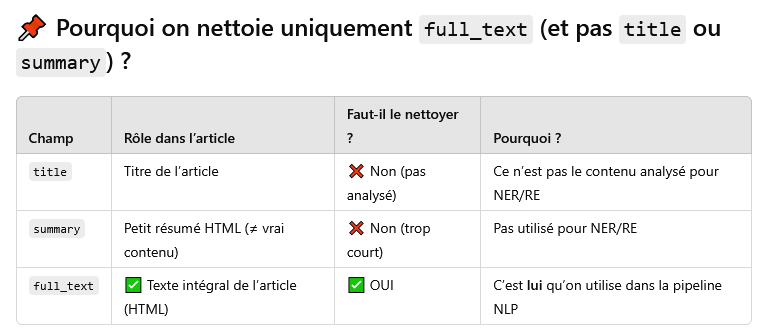

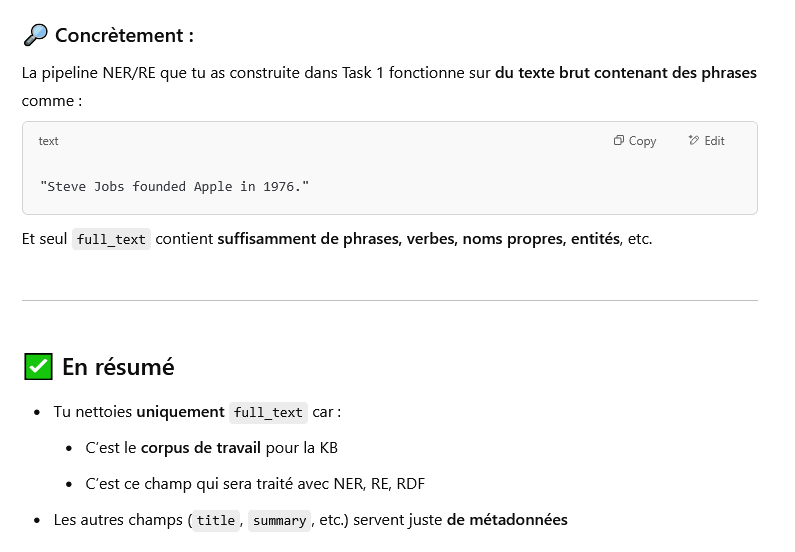

**Rappel des opérations:**

Pour chaque article :

- Lemmatisation

- Lowercase

- Suppression :

    - Ponctuation (sauf -)
    - Stopwords
    - Espaces vides

In [60]:
import spacy
import string

# Charger le modèle spaCy
nlp = spacy.load("en_core_web_sm")  # ou ton modèle custom

def clean_text(text):
    doc = nlp(text)
    cleaned_tokens = []
    for token in doc:
        if token.text in string.punctuation and token.text != "-":
            continue
        if token.is_stop:
            continue
        cleaned_tokens.append(token.lemma_.lower())
    return cleaned_tokens

Test sur le 1er article:

In [61]:
article_text = articles[0]["full_text"]  # Texte intégral du 1er article
cleaned = clean_text(article_text)

print("Texte original :")
print(article_text[:300], "...")  # pour visualiser rapidement

print("\nTokens nettoyés :")
print(cleaned[:50])  # premiers tokens nettoyés

Texte original :
Summary China hits back against Donald Trump's tariffs, saying it will imposean additional 34% tax on US goodsfrom next week European marketsfall further in response, with indexes in London, Berlin and Paris all down more than 3% Trump announced a 54% import tax for China - one of the highest rates  ...

Tokens nettoyés :
['summary', 'china', 'hit', 'donald', 'trump', 'tariff', 'say', 'imposean', 'additional', '34', 'tax', 'goodsfrom', 'week', 'european', 'marketsfall', 'response', 'index', 'london', 'berlin', 'paris', '3', 'trump', 'announce', '54', 'import', 'tax', 'china', '-', 'high', 'rate', 'country', 'need', 'catch', 'basics?read', 'summary', 'treasury', 'minister', 'tell', 'bbc', 'uk', 'isworke', 'pace"to', 'secure', 'deal', 'trade', 'tariff', 'affect', 'money?our', 'business', 'reporter']


### 2.2 Named Entity Recognition (NER)

On utilise le modèle `en_ner_conll03` comme demandé. 

In [62]:
from pathlib import Path
from spacy.util import load_model_from_path

def apply_ner_to_articles(articles):
    """
    Applique le modèle en_ner_conll03 sur le champ full_text de chaque article,
    et ajoute un champ 'entities' à chaque dictionnaire d'article.
    """
    # Charger ton modèle spaCy entraîné sur CoNLL-2003
    model_path = Path("en_ner_conll03/best_ner_model")
    ner_model = load_model_from_path(model_path)

    for article in articles:
        doc = ner_model(article["full_text"])
        entities = [(ent.text, ent.label_) for ent in doc.ents]
        article["entities"] = entities  # Ajoute les entités au dictionnaire de l'article

    return articles

Testons le code sur le premier article: 

In [63]:
articles = fetch_bbc_articles()
articles = apply_ner_to_articles(articles)

# ✅ Affichage du résultat pour le premier article
print("Entités détectées dans l'article 1 :")
for ent in articles[0]["entities"]:
    print(ent)

Entités détectées dans l'article 1 :
('China', 'LOC')
('Donald Trump', 'PER')
('US', 'LOC')
('European', 'MISC')
('London', 'LOC')
('Berlin', 'LOC')
('Paris', 'LOC')
('Trump', 'PER')
('China', 'LOC')
('Need', 'PER')
('BBC the', 'ORG')
('UK', 'LOC')
('US How', 'ORG')
('UK', 'LOC')
('Live Reporting Edited', 'ORG')
('Tinshui Yeung', 'PER')
('Rorey Bosotti', 'PER')
('Simon JackBusiness', 'PER')
('US', 'LOC')
('Black', 'LOC')
('US', 'LOC')
('US', 'LOC')
('Wall Street Crash', 'LOC')
('US', 'LOC')
('Kevin PeacheyCost', 'PER')
('Widespread', 'PER')
('Chinese', 'MISC')
('American', 'MISC')
('Chinese', 'MISC')
('US', 'LOC')
('Beijing', 'LOC')
('China', 'LOC')
('American', 'MISC')
('Trump', 'MISC')
('China', 'LOC')
('US', 'LOC')
('US', 'LOC')
('China', 'LOC')
('Taiwan', 'LOC')
('China', 'LOC')
('US', 'LOC')
('China', 'LOC')
('Beijing', 'LOC')
('Taiwan', 'LOC')
('China', 'LOC')
('US', 'MISC')
('China', 'LOC')
('Trump', 'PER')
('China', 'LOC')
('US', 'LOC')
('US', 'LOC')
('Donald Trump', 'PER')
('C

Notre modèle a bien détecté de nombreuses entités. On retrouve des noms de personnes comme "Donald Trump" ou "Elon Musk", des organisations comme "BMW", "Ford", ou "Oxford Economics", et des lieux comme "US", "Germany", "Japan", etc.

Il y a quelques erreurs (par exemple "Jaguar Land Rover" détecté comme personne), mais globalement, le modèle a bien capté les entités importantes.

### 2.3 Relation Extraction (RE) 

On utilise `spaCy en_core_web_sm` comme demandé. 

In [64]:
import spacy

def extract_relations_from_articles(articles):
    """
    Utilise spaCy en_core_web_sm pour extraire des relations (RE) pour chaque article,
    et ajoute un champ 'relations' à chaque dictionnaire d'article.
    """
    nlp = spacy.load("en_core_web_sm")

    for article in articles:
        doc = nlp(article["full_text"])
        relations = []

        for sent in doc.sents:
            for token in sent:
                # Règle 1 : Sujet - Verbe - Objet
                if token.dep_ == "ROOT" and token.pos_ == "VERB":
                    subj = [w for w in token.lefts if w.dep_ in ("nsubj", "nsubjpass")]
                    obj = [w for w in token.rights if w.dep_ in ("dobj", "attr", "pobj")]
                    if subj and obj:
                        relations.append((subj[0].text, token.lemma_, obj[0].text))

                # Règle 2 : Verbe + préposition
                if token.dep_ == "prep" and token.head.pos_ == "VERB":
                    pobj = [w for w in token.children if w.dep_ == "pobj"]
                    subj = [w for w in token.head.lefts if w.dep_ in ("nsubj", "nsubjpass")]
                    if subj and pobj:
                        verb_prep = f"{token.head.lemma_}_{token.text}"
                        relations.append((subj[0].text, verb_prep, pobj[0].text))

                # Règle 3 : "X is the CEO of Y"
                if token.text.lower() == "ceo":
                    subj = [w for w in token.head.lefts if w.dep_ in ("nsubj", "nsubjpass")]
                    pobj = [w for w in token.subtree if w.dep_ == "pobj"]
                    if subj and pobj:
                        relations.append((subj[0].text, "ceo_of", pobj[0].text))

        article["relations"] = relations  # Ajoute les relations à l'article

    return articles

Testons le code sur le premier article: 

In [65]:
articles = extract_relations_from_articles(articles)

print("Relations extraites pour l'article 1 :")
for r in articles[0]["relations"]:
    print(r)

Relations extraites pour l'article 1 :
('China', 'hit_against', 'tariffs')
('it', 'imposean_in', 'response')
('minister', 'tell', 'BBC')
('UK', 'isworke_at', 'pace"to')
('this', 'qualify_as', 'crash')
('crash', 'use_over', 'decades')
('market', 'lose_On', 'October')
('market', 'lose', '%')
('market', 'lose_in', 'day')
('market', 'lose_In', '1929')
('market', 'lose', '%')
('market', 'lose_in', 'days')
('market', 'lose_By', 'comparison')
('market', 'lose', '%')
('This', 'turn_into', 'crash')
('broker', 'say_to', 'me')
('what', 'know_as', 'pension')
('Hundreds', 'hold_in', 'pensions')
('Hundreds', 'hold_at', 'moment')
('rises', 'affect', 'pension')
('government', 'use', 'announcement')
('Beijing', 'place', 'controls')
('Beijing', 'place_on', 'elements')
('Beijing', 'place_in', 'production')
('goods', 'hit', 'hike')
('We', 'have', 'announcements')
('We', 'have_in', 'moments')
('steps', 'tie_to', 'concerns')
('it', 'add_to', 'list')
('move', 'ban', 'export')
('that', 'use_for', 'purposes')


Le modèle a réussi à extraire plusieurs relations sujet-verbe-objet à partir du texte. On voit par exemple des relations comme "Investors sell shares", "Toyota have example", "Ferrari announce hike", ou "drivers react to tariff". Certaines phrases sont un peu approximatives, mais globalement, la structure est là. Ça montre que tes règles RE fonctionnent bien sur un vrai article BBC.

### 2.4 Conversion en RDF

On utilise `RDFLib` comme demandé. 

In [66]:
from rdflib import Graph, Namespace, URIRef
import re

def clean_uri_component(text):
    """
    Nettoie une chaîne de texte pour en faire une URI valide :
    - remplace les espaces par des underscores
    - supprime tous les caractères non autorisés
    """
    text = text.strip()
    text = text.replace(" ", "_")
    text = re.sub(r'[^a-zA-Z0-9_\-]', '', text)  # conserve lettres, chiffres, _ et -
    return text

def build_rdf_graph_from_articles(articles):
    """
    Construit un graphe RDF à partir des relations extraites dans chaque article.
    """
    g = Graph()
    EX = Namespace(url)
    g.bind("ex", EX)

    for article in articles:
        for head, relation, tail in article.get("relations", []):
            # Nettoyage sécurisé de chaque composant
            head_uri = URIRef(EX[clean_uri_component(head)])
            relation_uri = URIRef(EX[clean_uri_component(relation)])
            tail_uri = URIRef(EX[clean_uri_component(tail)])
            g.add((head_uri, relation_uri, tail_uri))

    return g

Utilisation et affichage du graphe:

In [67]:
rdf_graph = build_rdf_graph_from_articles(articles)

# Afficher le graphe en format Turtle
print(rdf_graph.serialize(format="turtle"))

@prefix ex: <https://www.bbc.com/news/business> .

ex:Administration ex:contact_for ex:comment .

ex:Albanese ex:say_on ex:Thursday .

ex:Attention ex:turn_to ex:market .

ex:Bangakya ex:tell ex:agency .

ex:Barclaysbank ex:see ex:fall .

ex:Beijing ex:place ex:controls ;
    ex:place_in ex:production ;
    ex:place_on ex:elements .

ex:Boulos ex:expand_on ex:proposals .

ex:Butin ex:import_from ex:territory .

ex:Christina ex:say_as ex:tears .

ex:Coffin ex:make ex:journey ;
    ex:make_to ex:waters .

ex:Commission ex:deal_with ex:matters .

ex:Credit ex:see ex:website .

ex:Daimler ex:slip_by ex:5 .

ex:Delhi ex:sign ex:agreement .

ex:Department ex:say_On ex:Tuesday .

ex:Erdogan ex:rise_from ex:beginnings .

ex:F-150s ex:have ex:engines ;
    ex:have_For ex:example .

ex:FTA ex:talk_with ex:range .

ex:FTSE ex:drop_with ex:companies .

ex:Farrell ex:tell ex:Corporation .

ex:Fear ex:run_in ex:Windsor .

ex:France ex:collate_at ex: ;
    ex:collate_in ex:research .

ex:He ex:conven

Le graphe RDF a bien été généré avec plein de triplets différents. On retrouve les relations que tu avais extraites à partir des articles, comme "Investors sell shares", "Ferrari announce hike", ou "drivers react to tariff". Chaque triplet a été converti correctement en URI.

### 2.5 Export en RDF/XML

In [68]:
# 📁 Export du graphe en format RDF/XML (.rdf)
rdf_graph.serialize(destination="output/part1_task2_bbc_graph.rdf", format="xml")

# 📁 Export du graphe en format Turtle (.ttl)
rdf_graph.serialize(destination="output/part1_task2_bbc_graph.ttl", format="turtle")

<Graph identifier=Nd4250984682643d9b8ff47874c5ed17f (<class 'rdflib.graph.Graph'>)>

### 2.6 Visualisation du graph RDF

In [69]:
pip install networkx matplotlib

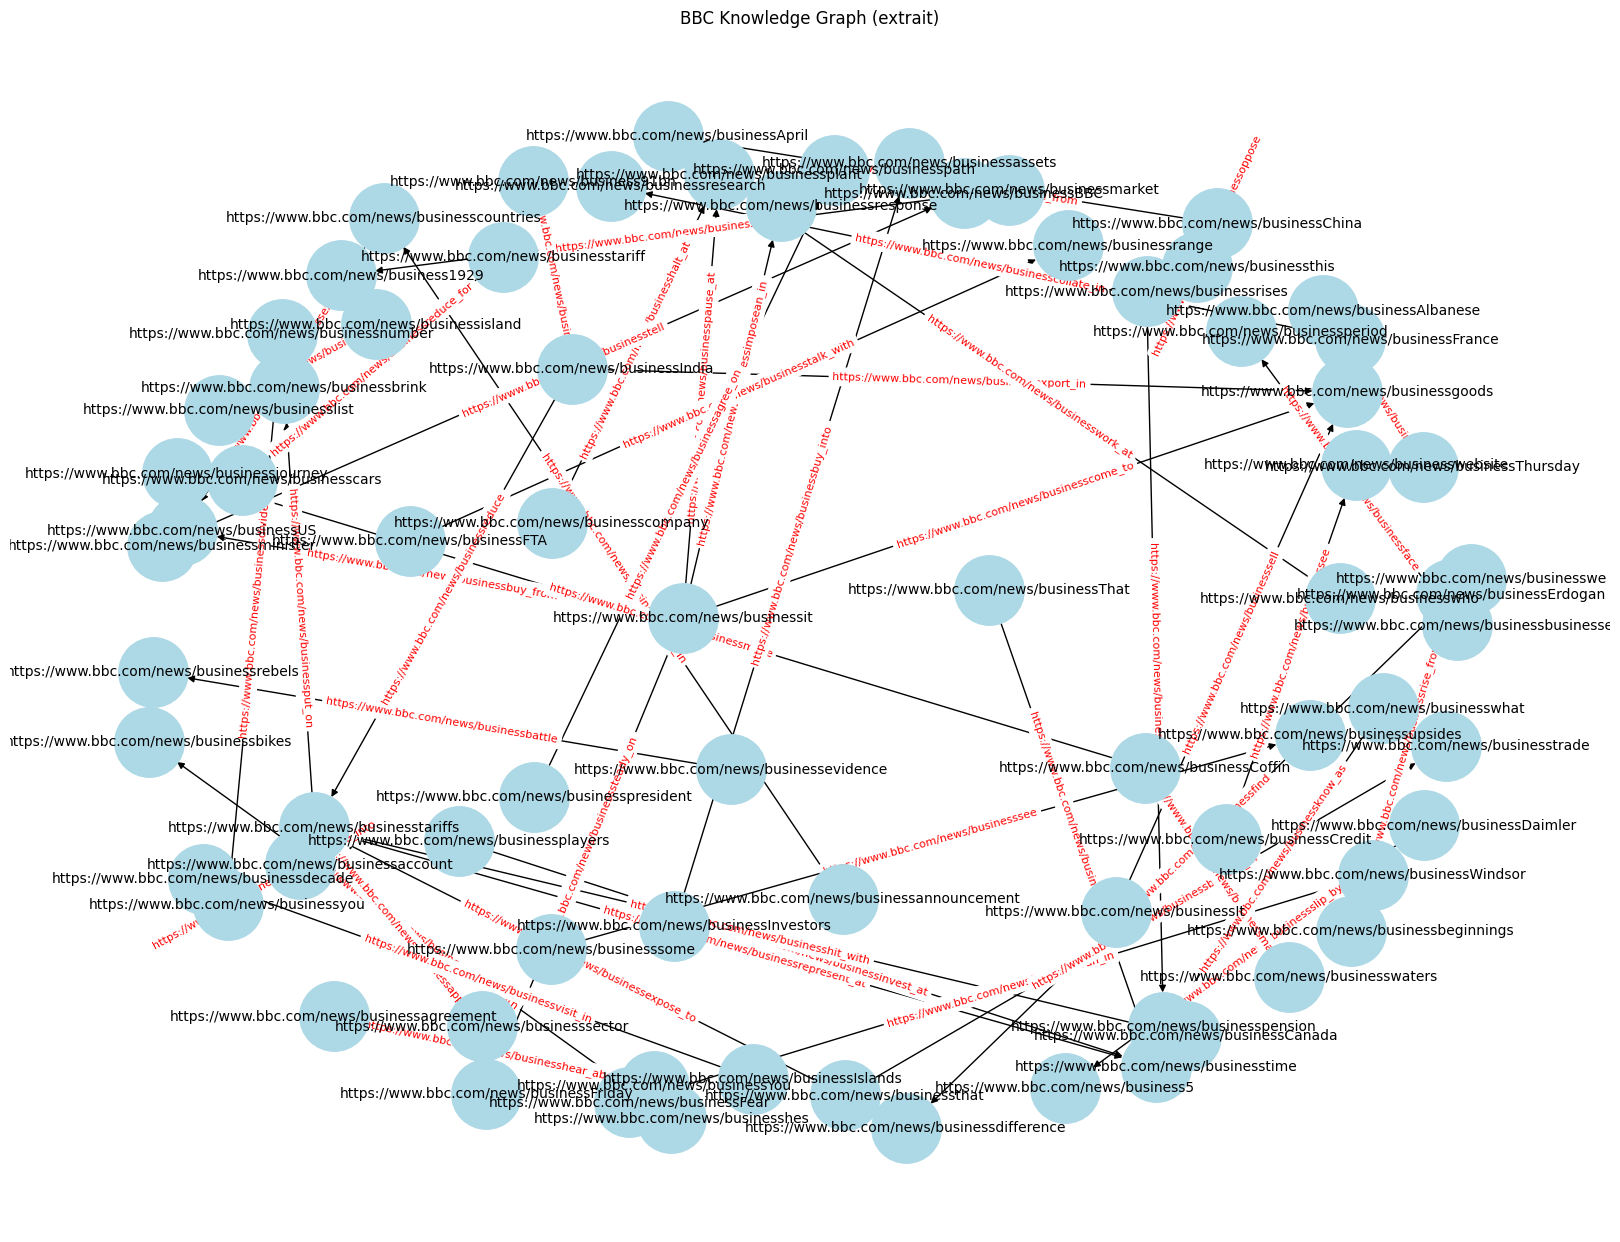

In [70]:
import networkx as nx
import matplotlib.pyplot as plt

def visualize_rdf_graph(graph, max_edges=50):
    """
    Visualise le graphe RDF avec networkx + matplotlib.
    max_edges : limite le nombre d'arêtes pour lisibilité
    """
    G = nx.DiGraph()

    for i, (s, p, o) in enumerate(graph):
        if i >= max_edges:
            break
        G.add_edge(str(s), str(o), label=str(p).split("#")[-1])

    pos = nx.spring_layout(G, k=1, iterations=50)
    edge_labels = nx.get_edge_attributes(G, 'label')

    plt.figure(figsize=(16, 12))
    nx.draw(G, pos, with_labels=True, node_color="lightblue", node_size=2500, font_size=10, arrows=True)
    nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_color='red', font_size=8)
    plt.title("BBC Knowledge Graph (extrait)")
    plt.axis("off")
    plt.show()

# ✅ Appel
visualize_rdf_graph(rdf_graph, max_edges=50)  # tu peux monter à 100+ si ton graphe est clair

Pour une meilleure visualisation: 

In [71]:
pip install pyvis

Note: you may need to restart the kernel to use updated packages.


In [72]:
from pyvis.network import Network

def visualize_rdf_graph_interactive(graph, filename="output/part1_task2_bbc_graph_visualisation.html", max_edges=100):
    """
    Visualise le graphe RDF de façon interactive avec pyvis.
    """
    net = Network(height="750px", width="100%", directed=True, notebook=True)
    net.force_atlas_2based()

    count = 0
    for s, p, o in graph:
        if count >= max_edges:
            break
        subj = str(s)
        pred = str(p).split("#")[-1]
        obj = str(o)

        net.add_node(subj, label=subj, title=subj)
        net.add_node(obj, label=obj, title=obj)
        net.add_edge(subj, obj, label=pred, title=pred)

        count += 1

    # Sauvegarder et afficher dans le navigateur
    net.show(filename)
    print(f"Graphe interactif généré : {filename}")

# ✅ Appel de la fonction
visualize_rdf_graph_interactive(rdf_graph)

output/part1_task2_bbc_graph_visualisation.html
Graphe interactif généré : output/part1_task2_bbc_graph_visualisation.html


Il faut ouvrir le fichier `bbc_graph_visualisation.html` qui dans le dossier `graphs` pour le voir dans un navigateur !!

## **Step 3 - Pipeline creation**

The user needs to choose a URL:

In [73]:
#url = "https://www.bbc.com/business" 
#url = "https://www.bbc.com/culture" 
url = "https://www.bbc.com/news/business" 

ETAPE 1 : RECUPÉRATION DES ARTICLES 

Article 1:
Title: China hits back at Trump tariffs with extra 34% tax on US goods, deepening market turmoil
URL: https://www.bbc.com/news/live/cvg52gjwg91t
Summary: Shares slump again after China, one of the hardest-hit countries by Donald Trump's raft of global tariffs, hits back.
Publication Date: Date inconnue
Author: Auteur inconnu
Full Text: Summary China hits back against Donald Trump's tariffs, saying it will imposean additional 34% tax on US goodsfrom next week European marketsfall further in response, with indexes in London, Berlin and Paris all down more than 3% Trump announced a 54% import tax for China - one of the highest rates for any country Need catching up on the basics?Read our summary here Meanwhile, a treasury minister tells the BBC the UK isworking "at pace"to secure a deal on trade with the US How could the tariffs ...


Article 2:
Title: Stocks slump as China retaliates to Trump tariffs
URL: https://www.bbc.com/news/articles/

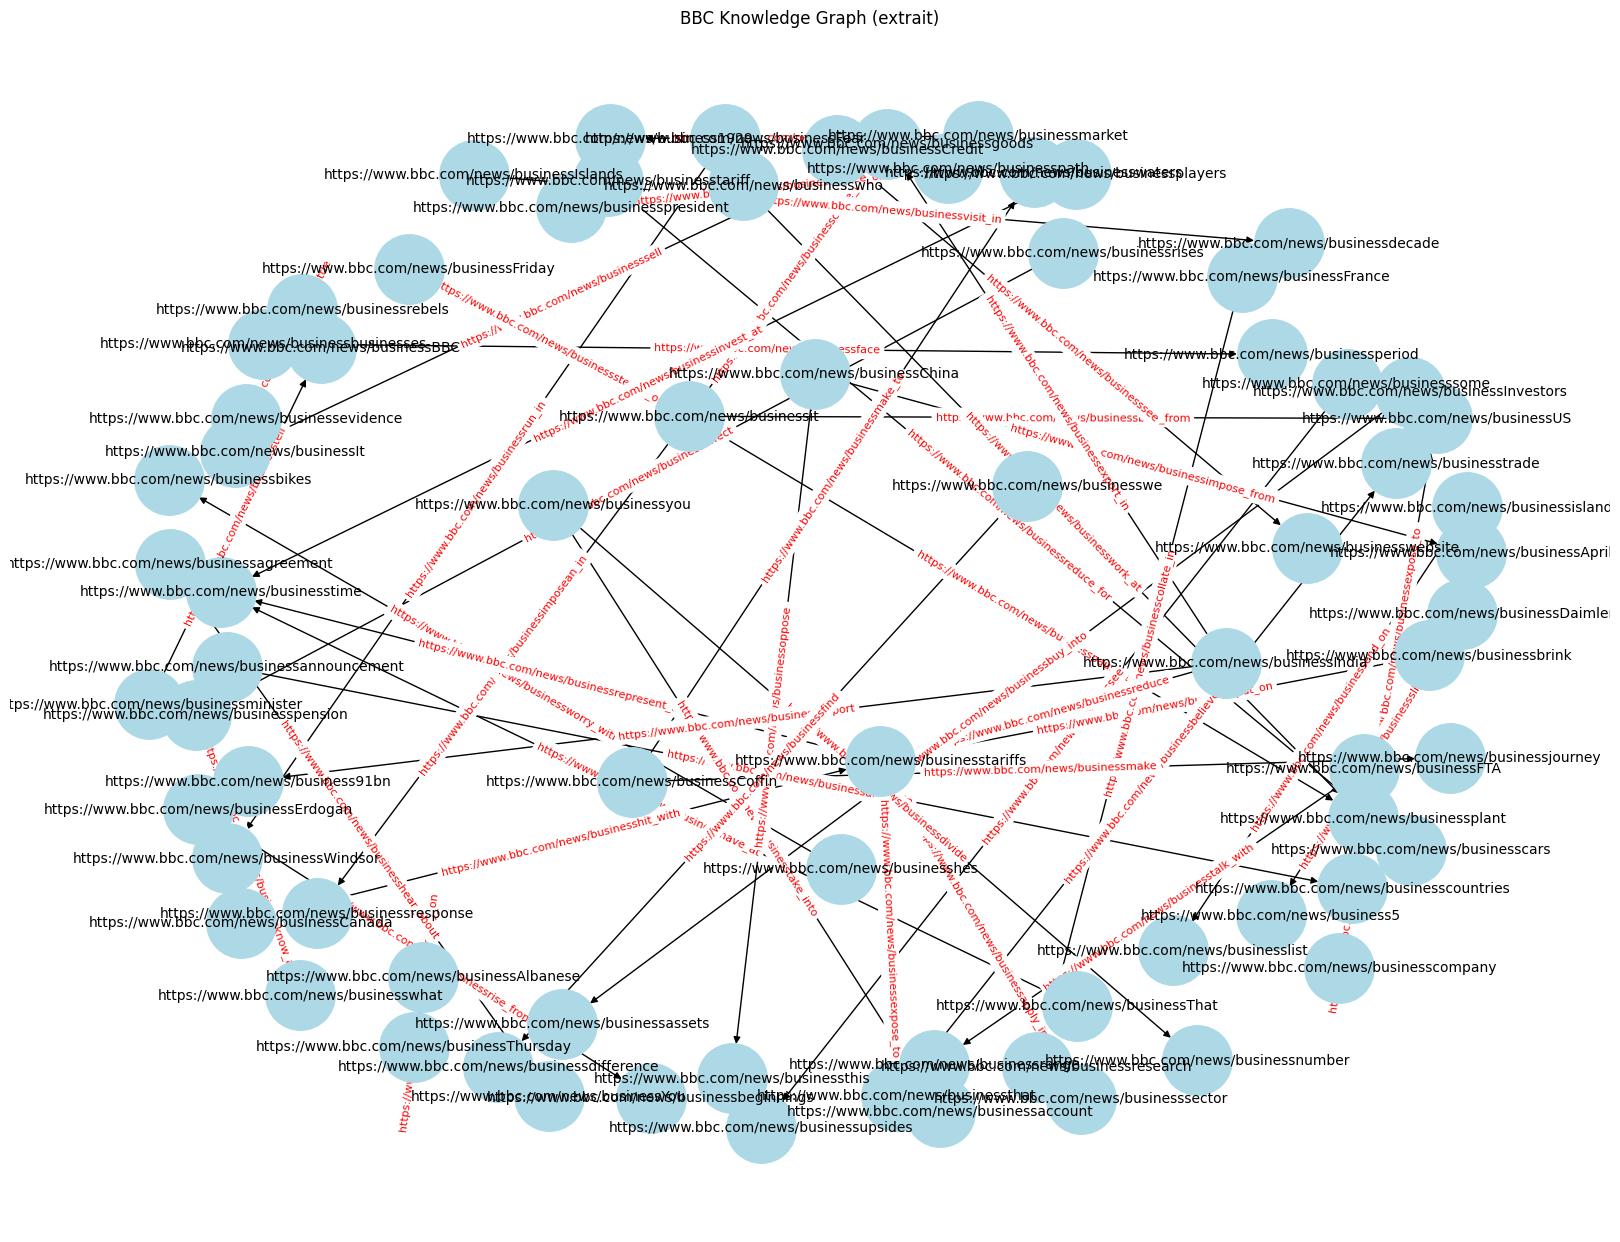

output/pipeline_bbc_news_business_graph_visualisation.html


Graphe interactif généré : output/pipeline_bbc_news_business_graph_visualisation.html


In [74]:
import requests
from bs4 import BeautifulSoup
import spacy
from spacy.util import load_model_from_path
from pathlib import Path
from rdflib import Graph, Namespace, URIRef
import re
import networkx as nx
import matplotlib.pyplot as plt
from pyvis.network import Network
import webbrowser
import os

from urllib.parse import urlparse
# 🔧 Créer un préfixe à partir de l'URL
parsed = urlparse(url)
domain = parsed.netloc.replace("www.", "").replace(".com", "")
domain_parts = domain.split(".")
domain_clean = "_".join(domain_parts) if domain_parts else domain
path_clean = parsed.path.strip("/").replace("/", "_")
site_prefix = f"pipeline_{domain_clean}_{path_clean}"

# ─────────────────────────────────────────────────────────────────────────────
# 1. Récupération des articles (scraping + texte intégral)
def fetch_articles_from_url(url, max_articles=10):
    """
    Récupère des articles à partir d'une URL d'index BBC News.
    """
    headers = {"User-Agent": "Mozilla/5.0"}
    response = requests.get(url, headers=headers)
    if response.status_code != 200:
        print("⚠ Erreur lors de la récupération des articles.")
        return []

    soup = BeautifulSoup(response.text, "html.parser")
    articles = []
    seen_titles = set()

    for article in soup.find_all("h2"):
        title = article.get_text(strip=True)
        parent = article.find_parent("a")
        content_tag = article.find_next("p")
        content = content_tag.get_text(strip=True) if content_tag else "Description non disponible"
        meta_div = article.find_next("div")
        date_span = meta_div.find("span") if meta_div else None
        publication_date = date_span.get_text(strip=True) if date_span else "Date inconnue"
        author_span = date_span.find_next_sibling("span") if date_span else None
        author = author_span.get_text(strip=True) if author_span else "Auteur inconnu"

        if parent and "href" in parent.attrs:
            link = parent["href"]
            if not link.startswith("http"):
                link = f"https://www.bbc.com{link}"

            # 🔁 Récupérer le texte intégral
            full_text = ""
            try:
                article_resp = requests.get(link, headers=headers)
                if article_resp.status_code == 200:
                    article_soup = BeautifulSoup(article_resp.text, "html.parser")
                    paragraphs = article_soup.find_all(["p", "h2"])
                    full_text = " ".join(p.get_text(strip=True) for p in paragraphs if p.get_text(strip=True))
                    if len(full_text) < 100:
                        full_text = "Texte complet non disponible"
            except:
                full_text = "Erreur récupération texte"

            if title not in seen_titles:
                seen_titles.add(title)
                articles.append({
                    "title": title,
                    "url": link,
                    "summary": content,
                    "date": publication_date,
                    "author": author,
                    "full_text": full_text
                })

        if len(articles) == max_articles:
            break

    return articles

# ─────────────────────────────────────────────────────────────────────────────
# 2. NER avec le modèle entraîné en_ner_conll03
def apply_ner_to_articles(articles):
    model_path = Path("en_ner_conll03/best_ner_model")
    ner_model = load_model_from_path(model_path)

    for article in articles:
        doc = ner_model(article["full_text"])
        entities = [(ent.text, ent.label_) for ent in doc.ents]
        article["entities"] = entities

    return articles

# ─────────────────────────────────────────────────────────────────────────────
# 3. Relation Extraction avec en_core_web_sm
def extract_relations_from_articles(articles):
    nlp = spacy.load("en_core_web_sm")

    for article in articles:
        doc = nlp(article["full_text"])
        relations = []

        for sent in doc.sents:
            for token in sent:
                if token.dep_ == "ROOT" and token.pos_ == "VERB":
                    subj = [w for w in token.lefts if w.dep_ in ("nsubj", "nsubjpass")]
                    obj = [w for w in token.rights if w.dep_ in ("dobj", "attr", "pobj")]
                    if subj and obj:
                        relations.append((subj[0].text, token.lemma_, obj[0].text))

                if token.dep_ == "prep" and token.head.pos_ == "VERB":
                    pobj = [w for w in token.children if w.dep_ == "pobj"]
                    subj = [w for w in token.head.lefts if w.dep_ in ("nsubj", "nsubjpass")]
                    if subj and pobj:
                        relations.append((subj[0].text, f"{token.head.lemma_}_{token.text}", pobj[0].text))

                if token.text.lower() == "ceo":
                    subj = [w for w in token.head.lefts if w.dep_ in ("nsubj", "nsubjpass")]
                    pobj = [w for w in token.subtree if w.dep_ == "pobj"]
                    if subj and pobj:
                        relations.append((subj[0].text, "ceo_of", pobj[0].text))

        article["relations"] = relations

    return articles

# ─────────────────────────────────────────────────────────────────────────────
# 4. Construction du graphe RDF
def clean_uri_component(text):
    """
    Nettoie une chaîne de texte pour en faire une URI valide :
    - remplace les espaces par des underscores
    - supprime tous les caractères non autorisés
    """
    text = text.strip()
    text = text.replace(" ", "_")
    text = re.sub(r'[^a-zA-Z0-9_\-]', '', text)  # conserve lettres, chiffres, _ et -
    return text

def build_rdf_graph_from_articles(articles):
    """
    Construit un graphe RDF à partir des relations extraites dans chaque article.
    """
    g = Graph()
    EX = Namespace(url)
    g.bind("ex", EX)

    for article in articles:
        for head, relation, tail in article.get("relations", []):
            # Nettoyage sécurisé de chaque composant
            head_uri = URIRef(EX[clean_uri_component(head)])
            relation_uri = URIRef(EX[clean_uri_component(relation)])
            tail_uri = URIRef(EX[clean_uri_component(tail)])
            g.add((head_uri, relation_uri, tail_uri))

    return g

# ─────────────────────────────────────────────────────────────────────────────
# 5. Visualisation statique 
def visualize_rdf_graph(graph, max_edges=50):
    G = nx.DiGraph()
    for i, (s, p, o) in enumerate(graph):
        if i >= max_edges:
            break
        G.add_edge(str(s), str(o), label=str(p).split("#")[-1])

    pos = nx.spring_layout(G, k=1.2)
    edge_labels = nx.get_edge_attributes(G, 'label')

    plt.figure(figsize=(16, 12))
    nx.draw(G, pos, with_labels=True, node_color="lightblue", node_size=2500, font_size=10, arrows=True)
    nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_color='red', font_size=8)
    plt.title("BBC Knowledge Graph (extrait)")
    plt.axis("off")
    plt.show()

# ─────────────────────────────────────────────────────────────────────────────
# 6. Visualisation interactive avec PyVis
def visualize_rdf_graph_interactive(graph, filename="output/pipeline_graph_visualisation.html", max_edges=100):
    """
    Visualise le graphe RDF de façon interactive avec pyvis.
    """
    net = Network(height="750px", width="100%", directed=True, notebook=True)
    net.force_atlas_2based()

    count = 0
    for s, p, o in graph:
        if count >= max_edges:
            break
        subj = str(s)
        pred = str(p).split("#")[-1]
        obj = str(o)

        net.add_node(subj, label=subj, title=subj)
        net.add_node(obj, label=obj, title=obj)
        net.add_edge(subj, obj, label=pred, title=pred)

        count += 1

    # Sauvegarder et afficher dans le navigateur
    net.show(filename)
    print(f"\n\nGraphe interactif généré : {filename}")

# ─────────────────────────────────────────────────────────────────────────────
# 7. EXPORT RDF
def export_rdf(graph, ttl_file=f"output/{site_prefix}_graph.ttl", rdf_file=f"output/{site_prefix}_graph.rdf"):
    graph.serialize(destination=ttl_file, format="turtle")
    graph.serialize(destination=rdf_file, format="xml")
    print(f"Graphes RDF exportés : {ttl_file}, {rdf_file}")


# ─────────────────────────────────────────────────────────────────────────────
# 8. PIPELINE FINALE

articles = fetch_articles_from_url(url)
print("ETAPE 1 : RECUPÉRATION DES ARTICLES \n")
for index, article in enumerate(articles, 1):
    print(f"Article {index}:")
    print(f"Title: {article['title']}")
    print(f"URL: {article['url']}")
    print(f"Summary: {article['summary']}")
    print(f"Publication Date: {article['date']}")
    print(f"Author: {article['author']}")
    print(f"Full Text: {article['full_text'][:500]}...")  # On limite à 500 caractères pour lisibilité
    print("\n")

articles = apply_ner_to_articles(articles)
print("=" * 120)
print("\nETAPE 2 : RECONNAISSANCE D'ENTITES (NER) \n")
print("Entités détectées dans l'article 1 :")
for ent in articles[0]["entities"]:
    print(ent)

articles = extract_relations_from_articles(articles)
print("\n")
print("=" * 120)
print("\nETAPE 3 : EXTRACTION DES RELATIONS (RE)\n")
print("Relations extraites pour l'article 1 :")
for r in articles[0]["relations"]:
    print(r)

rdf_graph = build_rdf_graph_from_articles(articles)
print("\n")
print("=" * 120)
print("\nETAPE 4: CONSTRUCTION DU GRAPHE RDF \n")
print(rdf_graph.serialize(format="turtle"))

# 📁 Export + Visualisation
print("=" * 120)
print("\nETAPE 5: EXPORT ET VISUALISATION DU GRAPHE RDF \n")
export_rdf(rdf_graph)
visualize_rdf_graph(rdf_graph, max_edges=50)
# 📁 Visualisation interactive avec nom personnalisé
visualize_rdf_graph_interactive(
    rdf_graph,
    filename=f"output/{site_prefix}_graph_visualisation.html"
)

The whole pipeline works super well. 

The output shows the result of every step.

Finally, 3 files are exported in the folder `graphs`. Go check it out!